In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util as len_plot_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util
from mejiro.utils import util

In [2]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')
r = np.load(os.path.join(ps_dir, 'r.npy'))

Grab all data where we vary subhalo populations

In [3]:
power_list_wdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_wdm.npy')))]
power_list_mdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_mdm.npy')))]
power_list_cdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_cdm.npy')))]

stack_list_wdm = np.vstack(power_list_wdm)
stack_list_mdm = np.vstack(power_list_mdm)
stack_list_cdm = np.vstack(power_list_cdm)

res_wdm = np.mean(stack_list_wdm, axis=0) - np.mean(stack_list_cdm, axis=0)
res_mdm = np.mean(stack_list_mdm, axis=0) - np.mean(stack_list_cdm, axis=0)

# TODO make percentile instead of std because doesn't reflect asymmetry of distribution
std_wdm = np.std(stack_list_wdm - stack_list_cdm, axis=0, ddof=1)
std_mdm = np.std(stack_list_mdm - stack_list_cdm, axis=0, ddof=1)

Grab all data where we vary detector positions

In [4]:
power_list_control = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_control.npy')))]
power_list_pos_1 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_1.npy')))]
power_list_pos_2 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_2.npy')))]
power_list_pos_3 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_3.npy')))]
# power_list_gaussian = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_gaussian.npy')))]

stack_control = np.vstack(power_list_control)
stack_list_pos_1 = np.vstack(power_list_pos_1)
stack_list_pos_2 = np.vstack(power_list_pos_2)
stack_list_pos_3 = np.vstack(power_list_pos_3)
# stack_list_gaussian = np.vstack(power_list_gaussian)

dif_pos_1 = np.mean(stack_list_pos_1, axis=0) - np.mean(stack_control, axis=0)
dif_pos_2 = np.mean(stack_list_pos_2, axis=0) - np.mean(stack_control, axis=0)
dif_pos_3 = np.mean(stack_list_pos_3, axis=0) - np.mean(stack_control, axis=0)
# dif_gaus = np.mean(stack_list_gaussian, axis=0) - np.mean(stack_control, axis=0)

std_pos_1 = np.std(stack_list_pos_1 - stack_control, axis=0, ddof=1)
std_pos_2 = np.std(stack_list_pos_2 - stack_control, axis=0, ddof=1)
std_pos_3 = np.std(stack_list_pos_3 - stack_control, axis=0, ddof=1)

Plot

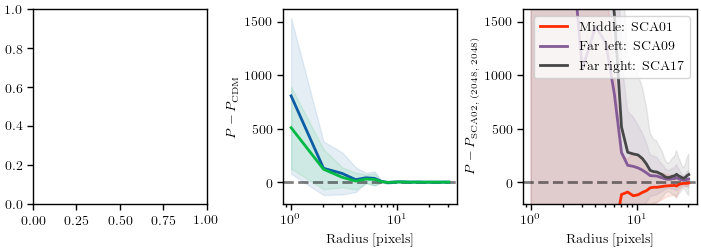

In [5]:
f, ax = plt.subplots(1, 3, figsize=(7, 2.5), constrained_layout=True)

# ax[0].loglog(bins_6, mean_6, alpha=1., color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
# ax[0].fill_between(bins_6, mean_6 - std_6, mean_6 + std_6, alpha=0.1, color='#0C5DA5')
# ax[0].loglog(bins_7, mean_7, alpha=1., color='#00B945', label='$\geq 10^7$ M$_\odot$')
# ax[0].fill_between(bins_7, mean_7 - std_7, mean_7 + std_7, alpha=0.1, color='#00B945')
# ax[0].loglog(bins_8, mean_8, alpha=1., color='#FF9500', label='$\geq 10^8$ M$_\odot$')
# ax[0].fill_between(bins_8, mean_8 - std_8, mean_8 + std_8, alpha=0.1, color='#FF9500')
# ax[0].set_xlabel('Halo mass [' + r'$M_{\odot}$]')
# ax[0].set_ylabel('Count')
# ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[1].plot(r, res_wdm, color='#0C5DA5')
ax[1].fill_between(r, res_wdm - std_wdm, res_wdm + std_wdm, alpha=0.1, color='#0C5DA5')
ax[1].plot(r, res_mdm, color='#00B945')
ax[1].fill_between(r, res_mdm - std_mdm, res_mdm + std_mdm, alpha=0.1, color='#00B945')
ax[1].set_xscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'$P - P_{\textrm{CDM}}$')

ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[2].plot(r, dif_pos_1, color='#FF2C00', label='Middle: SCA01')
ax[2].plot(r, dif_pos_2, color='#845B97', label='Far left: SCA09')
ax[2].plot(r, dif_pos_3, color='#474747', label='Far right: SCA17')
ax[2].fill_between(r, dif_pos_1 - std_pos_1, dif_pos_1 + std_pos_1, alpha=0.1, color='#FF2C00')
ax[2].fill_between(r, dif_pos_2 - std_pos_2, dif_pos_2 + std_pos_2, alpha=0.1, color='#845B97')
ax[2].fill_between(r, dif_pos_3 - std_pos_3, dif_pos_3 + std_pos_3, alpha=0.1, color='#474747')
ax[2].set_xscale('log')
ax[2].set_xlabel('Radius [pixels]')
ax[2].set_ylabel(r'$P - P_{\textrm{SCA02, (2048, 2048)}}$')
ax[2].legend()
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[2].sharey(ax[1])

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()